In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Statistics

In [2]:
# Statistics for listings.csv dataset:
# read the dataset
listings_df = pd.read_csv('Boston Airbnb/listings.csv')

# find number of listings and number of hosts
listings_number = listings_df['id'].count()
hosts_number = len(listings_df['host_id'].unique())

print('listings.csv dataset contains information on %d listings provided by %d hosts.' % (listings_number, hosts_number))

listings.csv dataset contains information on 3585 listings provided by 2181 hosts.


<Axes: title={'center': 'Missing values per column, Under 50%'}>

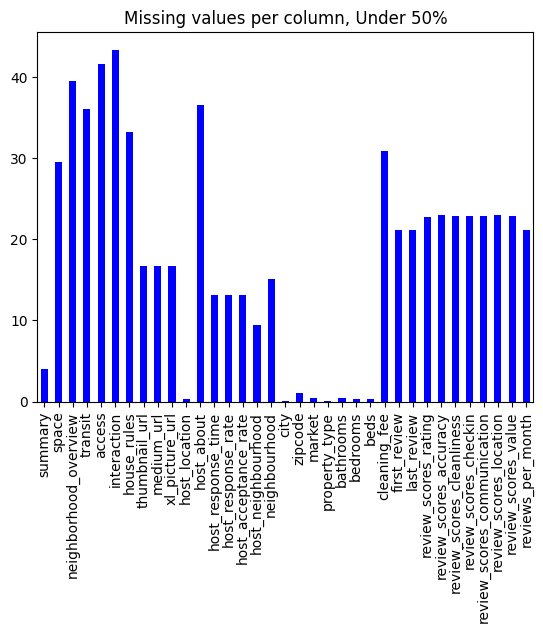

In [3]:
#find percentage of missing values for each column
listings_missing_df = listings_df.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[(listings_missing_df > 0) & (listings_missing_df < 50)]
listings_columns_with_nan.plot.bar(title='Missing values per column, Under 50%',color='blue')


<Axes: title={'center': 'Missing values per column in percentage, Above 50%'}>

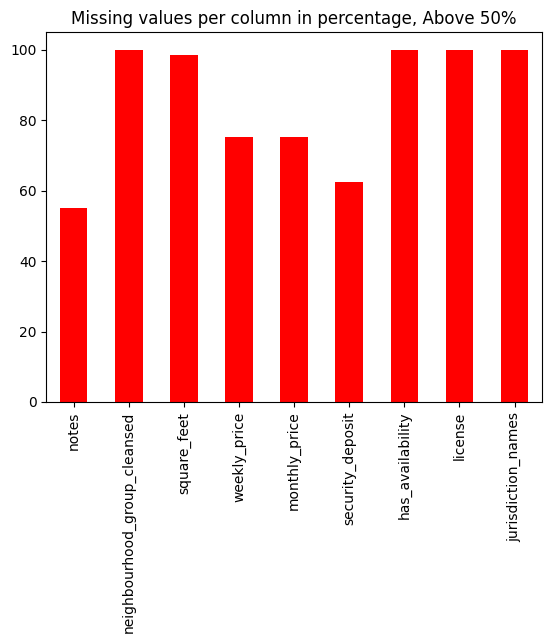

In [4]:
#plot the results
listings_columns_with_nan = listings_missing_df[listings_missing_df >= 50]
listings_columns_with_nan.plot.bar(title='Missing values per column in percentage, Above 50%',color='red')


Statistics for calendar.csv dataset:

In [5]:
#read the dataset
calendar_df = pd.read_csv('Boston Airbnb/calendar.csv')

#find number of rows in dataset
rows_num = calendar_df.shape[0]

#find first and last date of the calendar
min_date = calendar_df['date'].min()
max_date = calendar_df['date'].max()

print('calendar.csv dataset contains %d rows.' % (rows_num))
print('The first date of observation is %s and the last date is %s.' % (min_date, max_date))

calendar.csv dataset contains 1308890 rows.
The first date of observation is 2016-09-06 and the last date is 2017-09-05.


calendar.csv dataset missing values statistics

<Axes: title={'center': 'Missing values per column, %'}>

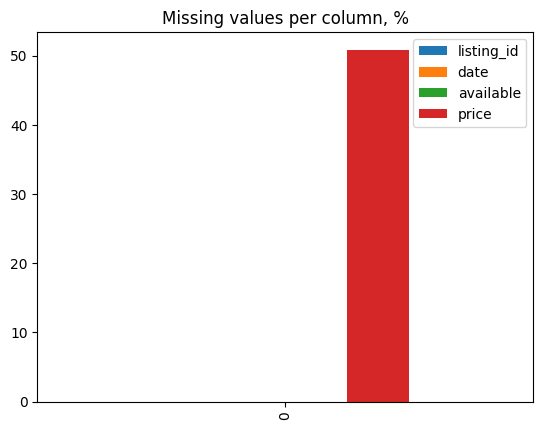

In [6]:
#get percentage of missing values for each column in dataset
calendar_missing_df = pd.DataFrame([calendar_df.isnull().mean()*100])

#plot the results
calendar_missing_df.plot.bar(title='Missing values per column, %')

## Data Preprocessing

In [7]:
def get_month_from_date(row):
    """Extracts month from a date string."""
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    """Extracts year from a date string."""
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    """Extracts the year from the 'host_since' date string, returns NaN for missing values."""
    try:
        return int(row['host_since'].split('-')[0])
    except ValueError:
        return np.nan

def fill_dummy_column(row, column_name, value):
    """Creates a dummy variable indicating presence of a specified value in a list-like column."""
    try:
        values = row[column_name].translate(str.maketrans('', '', '[]{}\'"')).split(',')
        return 1.0 if value in values else 0.0
    except KeyError:
        return 0.0

def split_list_to_columns(df, column_name, max_columns=10):
    """Expands list-like column into multiple dummy columns for its most common values."""
    value_counts = {}
    for item_list in df[column_name].unique():
        for item in item_list.translate(str.maketrans('', '', '[]{}\'"')).split(','):
            value_counts[item] = value_counts.get(item, 0) + 1

    for value, _ in sorted(value_counts.items(), key=lambda x: x[1], reverse=True)[:max_columns]:
        new_column_name = f"{column_name}_{value}"
        df[new_column_name] = df.apply(fill_dummy_column, args=(column_name, value), axis=1)

def get_extra_people_fee(row):
    """Checks if there's a fee for extra people, returns 1 for yes, 0 for no."""
    return 0.0 if row['extra_people'] == '$0.00' else 1.0

def convert_currency_to_float(currency_str):
    """Converts a currency string to a float value."""
    if pd.notna(currency_str):
        return float(currency_str.replace('$', '').replace(',', ''))
    return currency_str


In [9]:
def clean_dataset(listings_df, calendar_df, columns_to_keep):
    """
    Cleans and merges Airbnb listings and calendar datasets.

    - Merges datasets on 'listing_id'.
    - Filters for selected columns.
    - Converts date strings to numerical values and categorizes 'host_response_rate'.
    - Splits list-like columns into multiple dummy columns.
    - Imputes missing values.
    """
    listings_df = listings_df.rename(columns={"id": "listing_id"})
    merged_df = pd.merge(calendar_df, listings_df, on='listing_id')
    merged_df = merged_df[columns_to_keep]

    # Write unique counts to a file for inspection
    with open('Temp_Result/unique_count.txt', 'w', encoding='utf-8') as file:
        for column in merged_df.columns:
            file.write(f'{column}: {len(merged_df[column].unique())}\n')

    merged_df['month'] = merged_df.apply(get_month_from_date, axis=1)
    merged_df['year'] = merged_df.apply(get_year_from_date, axis=1)

    merged_df.dropna(subset=['price_x'], inplace=True)
    merged_df['price'] = merged_df['price_x'].astype(str).apply(convert_currency_to_float)

    merged_df['host_since_year'] = merged_df.apply(get_host_since_year, axis=1)
    merged_df['host_since_year'].fillna(merged_df['host_since_year'].mean(), inplace=True)

    merged_df['host_response_rate_num'] = merged_df['host_response_rate'].str.replace("%", "").astype(float)
    merged_df['host_response_rate_buckets'] = pd.qcut(merged_df['host_response_rate_num'], 5, labels=False, duplicates='drop')

    merged_df['host_listings_count'].fillna(merged_df['host_listings_count'].mean(), inplace=True)

    for column in ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'instant_bookable', 'bed_type']:
        split_list_to_columns(merged_df, column)

    for column in ['bathrooms', 'bedrooms', 'beds']:
        merged_df[column].fillna(merged_df[column].mode()[0], inplace=True)

    merged_df['extra_people_fee'] = merged_df.apply(get_extra_people_fee, axis=1)

    review_scores_columns = [
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ]
    for column in review_scores_columns:
        merged_df[column].fillna(merged_df[column].mean(), inplace=True)

    return merged_df

# Example usage
columns_to_keep = ['calculated_host_listings_count', 'host_has_profile_pic', 'access', 'minimum_nights', 'bathrooms', 'date', 'price_x',
'host_response_rate', 'host_listings_count', 'review_scores_communication', 'host_identity_verified', 'review_scores_accuracy',
'room_type', 'beds', 'cancellation_policy', 'amenities', 'number_of_reviews', 'host_is_superhost', 'bedrooms', 'extra_people',
'review_scores_value', 'host_verifications', 'property_type', 'review_scores_rating', 'review_scores_checkin', 'host_since',
'guests_included', 'review_scores_location', 'require_guest_profile_picture', 'review_scores_cleanliness', 'instant_bookable',
'require_guest_phone_verification', 'accommodates', 'listing_id', 'host_response_time', 'maximum_nights', 'bed_type',
'neighbourhood_group_cleansed', 'interaction', 'house_rules', 'city']

# apply functions above to clean dataset
transform_df = clean_dataset(listings_df, calendar_df,columns_to_keep)
transform_df.shape


(643037, 61)

In [10]:
# drop temporary columns as a result of preprocessing
col_to_drop = ['date','price_x','host_since','host_response_rate', 'host_response_rate_num',
                'host_has_profile_pic', 'host_identity_verified','host_is_superhost',
                'instant_bookable','bed_type','extra_people']
df = transform_df.drop(columns=col_to_drop)
df.shape

(643037, 50)

## Data Analysis

### What are the price distribution between city

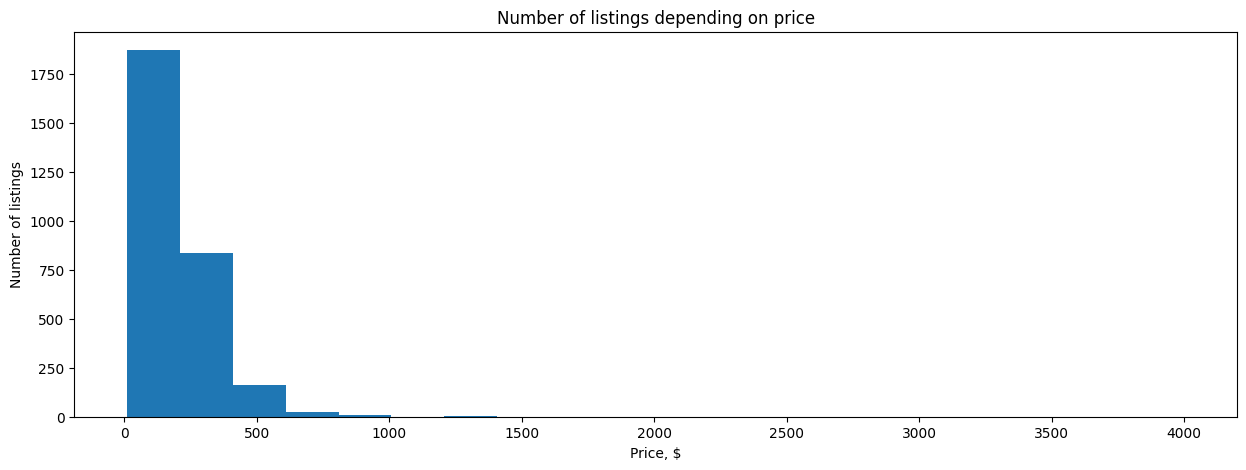

In [11]:
#get the average price for each listing
mean_price_for_listing = df.groupby('listing_id')['price'].mean()

#plot
plt.figure(figsize=(15,5))
plt.hist(mean_price_for_listing, bins=20)
plt.ylabel('Number of listings')
plt.xlabel('Price, $')
plt.title('Number of listings depending on price')
plt.show()

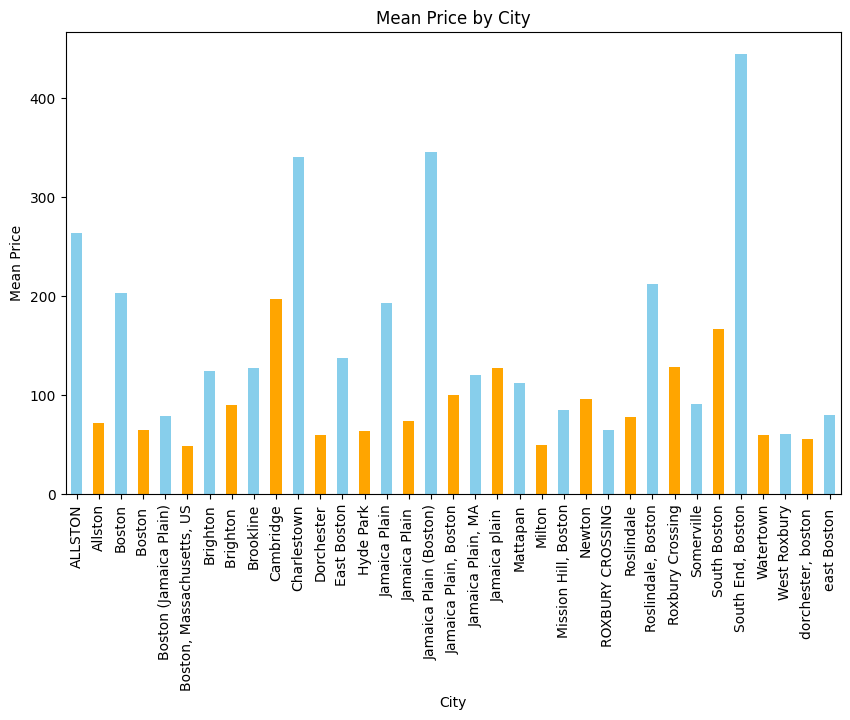

In [12]:
# Grouping by 'Category' and calculating mean of 'Value'
mean_values = df.groupby('city')['price'].mean()

# Plotting
plt.figure(figsize=(10, 6))  # Increase figure size (width, height) in inches
mean_values.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Mean Price by City')
plt.xlabel('City')
plt.ylabel('Mean Price')
plt.xticks(rotation=90)  # Rotate category labels for better readability
plt.show()


### What Are the Busiest Times of the Year to Visit Boston?

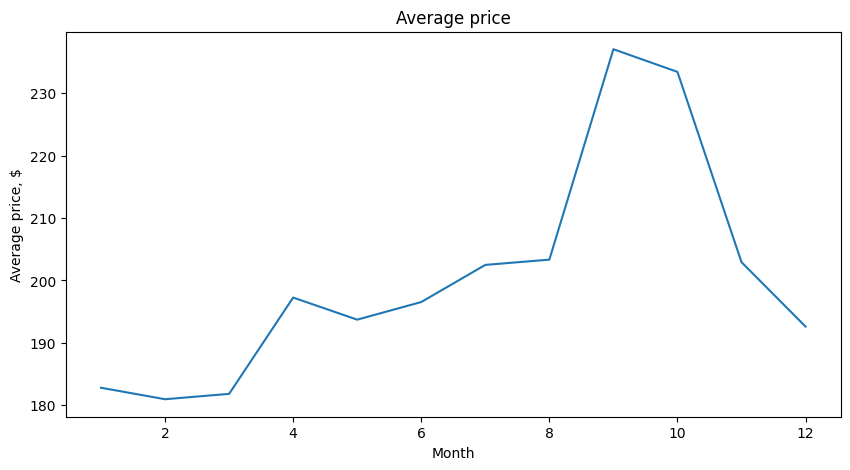

In [13]:
#find average price by month
average_price_by_month = df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')
plt.show()

### Correlation between Price and Other Features

In [14]:
# get all the numerical column in the dataset
numerical_columns = ['price']
for i in range(len(df.dtypes)):
    if df.columns[i] in columns_to_keep:
        if df.dtypes[i] != object:
            numerical_columns.append(df.columns[i])


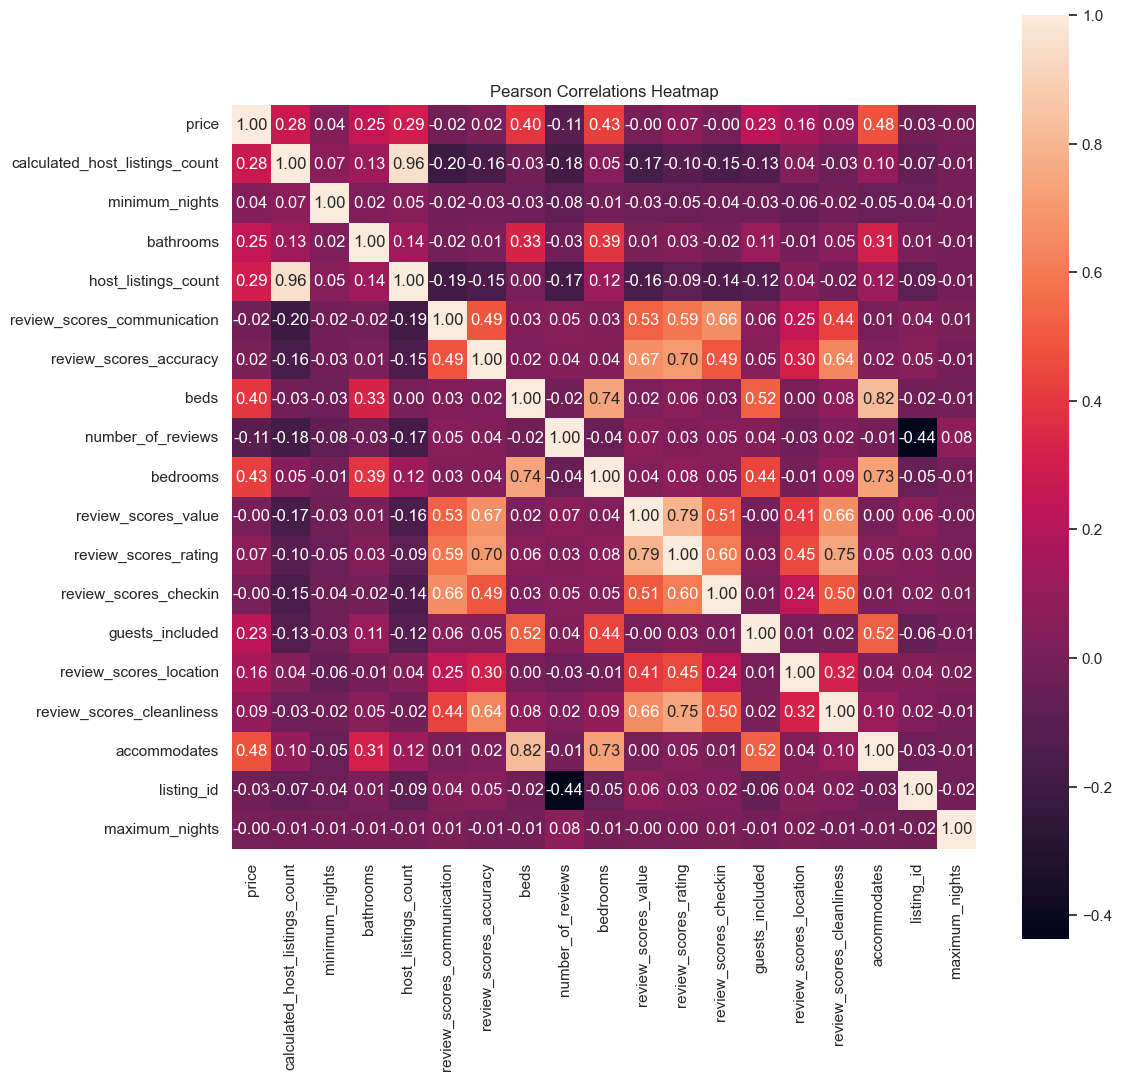

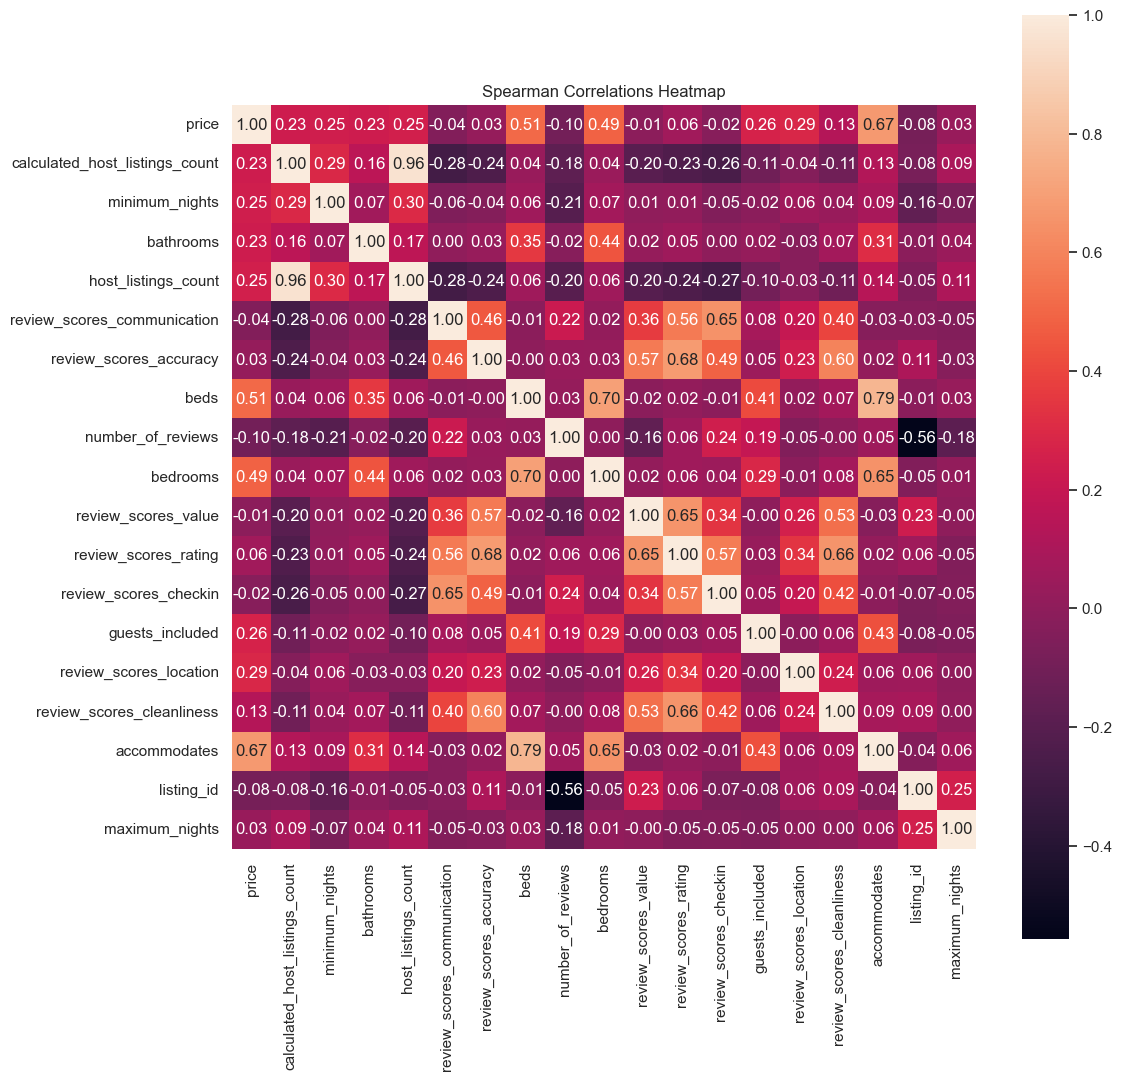

In [15]:
# Numerical columns to find out correlation
# Remove 'neighbourhood_group_cleansed' because of missing values
cols = [col for col in numerical_columns if col != 'neighbourhood_group_cleansed']
correlation_name_list = ['pearson','spearman']
plotname_list = ['Pearson','Spearman']

def plot_corelation(correlation_name,plotname):
    # Compute the Pearson correlation matrix
    corr = df[cols].corr(method=correlation_name)

    # Plotting the Pearson correlation heatmap
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1)
    plt.title(f'{plotname} Correlations Heatmap')
    sns.heatmap(corr, cbar=True, annot=True, square=True, fmt='.2f',
                yticklabels=cols, xticklabels=cols)
    plt.show()

for i in range(len(correlation_name_list)):
    plot_corelation(correlation_name_list[i],plotname_list[i])

C:\Users\User\AppData\Local\Temp\ipykernel_15776\3583131028.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.violinplot(x='room_type', y='price', data=df[df['price'] < 7000][df['room_type'].isin(['Private room','Shared room'])])


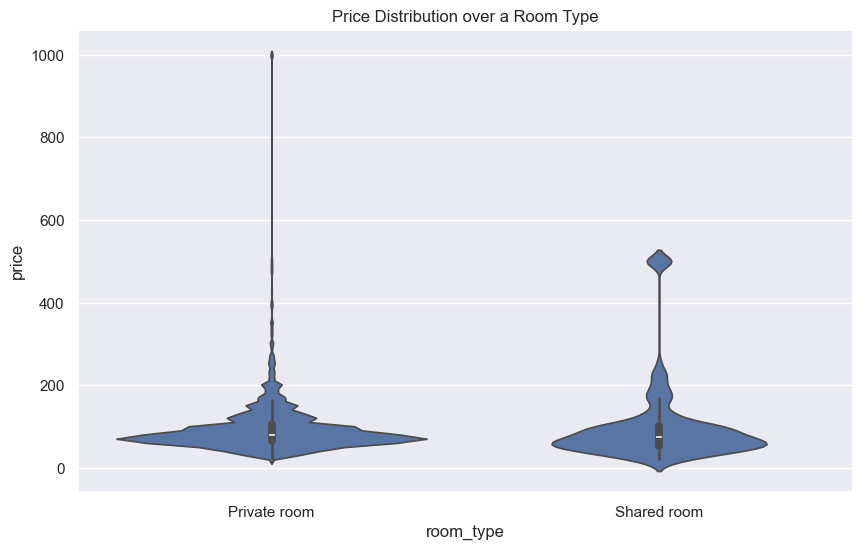

In [16]:
# There is one outlier price 7163.0 that is removed for suitable visualization
# Creating a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='room_type', y='price', data=df[df['price'] < 7000][df['room_type'].isin(['Private room','Shared room'])])
plt.title('Price Distribution over a Room Type')
plt.show()


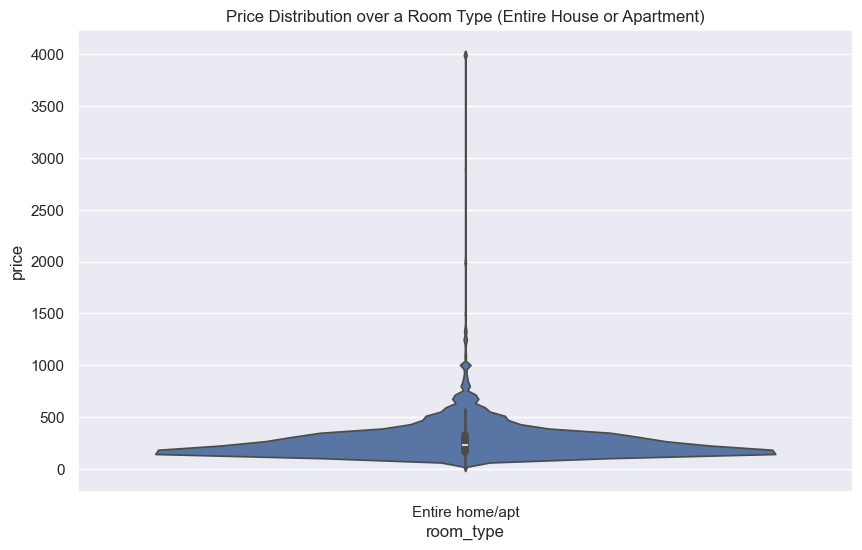

In [17]:
# plot separately for Entire House or Apartment as the price range is different
plt.figure(figsize=(10, 6))
sns.violinplot(x='room_type', y='price', data=df[df['room_type'].isin(['Entire home/apt'])])
plt.title('Price Distribution over a Room Type (Entire House or Apartment)')
plt.show()


## Machine Learning for Further Analysis

In [18]:
# turn categorical columns with relatively low dimensions into dummies
cat_columns = list(df.select_dtypes(include=['object']).columns)
too_many_dims_column = ['access','amenities','host_verifications','house_rules','interaction']
cat_columns = [x for x in cat_columns if x not in too_many_dims_column]
# excluding the many unique value such as access, amenities and etc.

for col in  cat_columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',
                                                         drop_first=True, dummy_na=True)], axis=1)

#drop listing_id and year columns
df = df.drop(columns = ['listing_id', 'year','access','amenities','host_verifications' ,'interaction','house_rules'])
df.shape

(643037, 99)

In [19]:
#prepare train and test datasets for modelling
TEST_SIZE = 0.3
RAND_STATE = 42

X = df.drop(columns = 'price')
y = df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

Train Random Forest Regressor and XG Boost models to predict price:

In [20]:
def visualize_result(model_name, model):
    print('MODEL:',model_name)

    #calculate scores for the model
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)

    print('MSE train: %.3f, test: %.3f' % (
            mean_squared_error(y_train, y_train_preds),
            mean_squared_error(y_test, y_test_preds)))
    print('R^2 train: %.3f, test: %.3f' % (
            r2_score(y_train, y_train_preds),
            r2_score(y_test, y_test_preds)))

    #get feature importances from the model
    headers = ["name", "score"]
    values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    forest_feature_importances = pd.DataFrame(values, columns = headers)
    forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

    features = forest_feature_importances['name'][:15]
    y_pos = np.arange(len(features))
    scores = forest_feature_importances['score'][:15]

    #plot feature importances
    plt.figure(figsize=(10,5))
    plt.bar(y_pos, scores, align='center', alpha=0.5)
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature importances')
    plt.show()

MODEL: Random Forest
MSE train: 1661.326, test: 1802.979
R^2 train: 0.949, test: 0.944


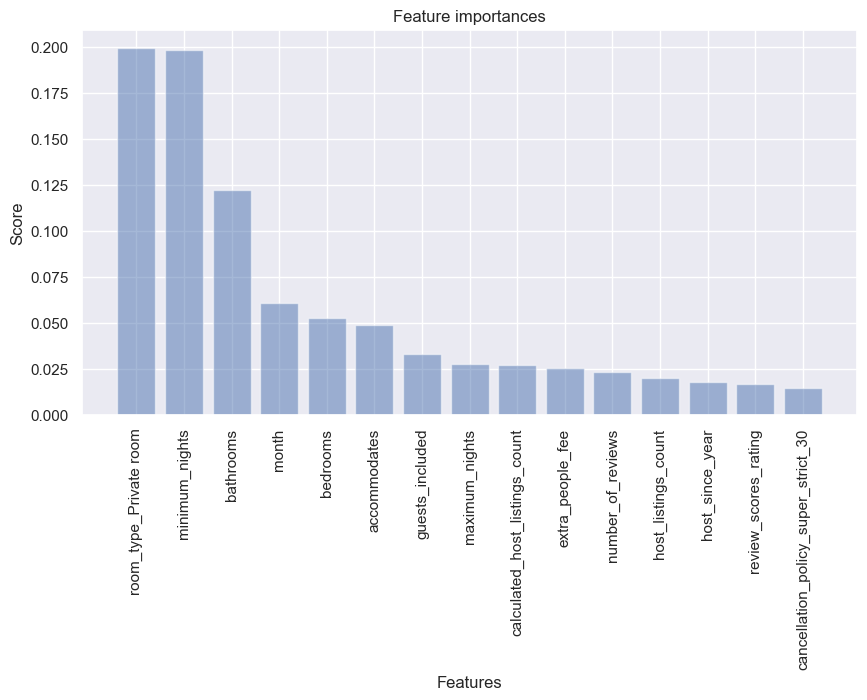

MODEL: XG Boost
MSE train: 3718.211, test: 3611.405
R^2 train: 0.886, test: 0.887


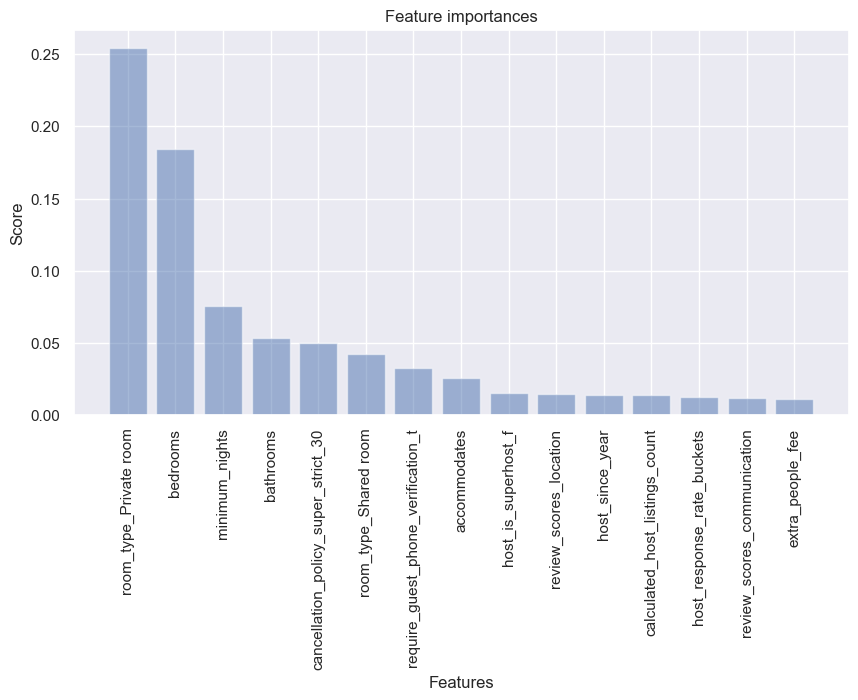

In [21]:
# train RF regressor and XGBoost models
model_name_ls = ["Random Forest","XG Boost"]
model_ls = [
    RandomForestRegressor(n_estimators=100, random_state=RAND_STATE),
    xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
]
fit_code_ls = ["model.fit(X_train, y_train.squeeze())","model.fit(X_train,y_train)"]

for i in range(len(model_name_ls)):
    # fit the model and visualize the result
    model = model_ls[i]
    eval(fit_code_ls[i])
    visualize_result(model_name_ls[i],model_ls[i])
